In [1]:
import numpy as np
from tqdm import tqdm

In [2]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '1'

import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Lambda, BatchNormalization
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.objectives import binary_crossentropy, mse
from keras.losses import mean_squared_error
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

tf.set_random_seed(1)
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [171]:
def get_two_head_gen(input_shape, noise_shape, n_layers, thickness, encoding_dim, optimizer):
    input_main = Input(shape=(input_shape, ), name='input_main')
    input_noise = Input(shape=(noise_shape, ), name='input_noise')
    
    x = keras.layers.concatenate([input_noise, input_main])
    
    for i in range(n_layers - 1):
        x = Dense(thickness*2, activation='relu')(x)
        x = BatchNormalization()(x)
        x = keras.layers.concatenate([x, input_main])
        
    y_1 = Dense(thickness, activation='relu')(x)
    y_1 = BatchNormalization()(y_1)
    y_1 = keras.layers.concatenate([y_1, input_main])
    generated_1 = Dense(encoding_dim, name='generated_1')(y_1)
    
    
    y_2 = Dense(thickness, activation='relu')(x)
    y_2 = BatchNormalization()(y_2)
    y_2 = keras.layers.concatenate([y_2, input_main])
    generated_2 = Dense(encoding_dim, name='generated_2')(y_1)
    
    
    gen_1 = Model([input_noise, input_main], generated_1, name="gen_1")
    gen_2 = Model([input_noise, input_main], generated_2, name="gen_2")
    
    gen_1.compile(loss='mean_squared_error', optimizer=optimizers.Adam(0.0005))
    
    gen_2.compile(loss='mean_squared_error', optimizer=optimizers.Adam(0.0005))
    
    return gen_1, gen_2

In [172]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def get_discriminator(input_shape, alpha_shape, n_layers, thickness, optimizer):
    input_alpha = Input(shape=(alpha_shape, ), name='input_main')
    inputs = Input(shape=(input_shape, ), name='input')
    
    x = keras.layers.concatenate([inputs, input_alpha])
    
    for i in range(n_layers - 1):
        x = Dense(thickness*2, activation='relu')(x)
        x = BatchNormalization()(x)
        x = keras.layers.concatenate([x, input_alpha])
        
    out = Dense(1, name='out')(x)
    
    disc = Model([inputs, input_alpha], out, name="disc")
    
    disc.compile(loss=wasserstein_loss, optimizer=optimizers.Adam(0.0005))
    
    return disc

In [173]:
def get_gan_network(generator, discriminator, input_shape, noise_shape, optimizer):
    for layer in discriminator.layers:
        layer.trainable = False
    discriminator.trainable = False
    
    gan_input_main = Input(shape=(input_shape,))
    gan_input_noise = Input(shape=(noise_shape,))
    x = generator([gan_input_noise, gan_input_main])
    gan_output = discriminator([x, gan_input_main] )
    
    gan = Model(inputs=[gan_input_noise, gan_input_main], outputs=gan_output)
    gan.compile(loss=wasserstein_loss, optimizer=optimizers.Adam(0.0005))
    
    return gan

In [174]:
def generate_input(uniform_bounds, uniform_dim, normal_dim, batch_size):
    alpha = np.random.uniform(*uniform_bounds, size=uniform_dim)
    return alpha, np.array([np.random.normal(alpha, 1, size=normal_dim) for i in range(batch_size)])

def generate_data(bounds, batch_size, normal_dim=1024, num=10000):
    alphas = []
    datas = []

    for i in range(num):
        alpha, data = generate_input(bounds, 1, normal_dim, batch_size)
        alphas.append(alpha)
        datas.append(data.reshape((data.size, 1)))

    return np.array(alphas), np.array(datas)

In [21]:
# alpha_01, data_01 = generate_data([0, 1], 1)
# np.save("alpha_01_1dim", alpha_01)
# np.save("data_01_1dim", data_01)

# alpha_02, data_02 = generate_data([0, 2], 1)
# np.save("alpha_02_1dim", alpha_02)
# np.save("data_02_1dim", data_02)

# alpha_12, data_12 = generate_data([1, 2], 1, num=1000)
# np.save("alpha_12_1dim", alpha_12)
# np.save("data_12_1dim", data_12)

In [17]:
np.array(data_01).shape

(10000, 1024, 1)

In [8]:
# alphas, digits from normal distbution for alpha \in [0,1]
alpha_01 = np.load("alpha_01.npy")[:5000]
data_01 = np.load("data_01.npy")[:5000]

# alphas, digits from normal distbution for alpha \in [0,2]
alpha_02 = np.load("alpha_02.npy")[:5000]
data_02 = np.load("data_02.npy")[:5000]

# alphas, digits from normal distbution for alpha \in [1,2]
alpha_12 = np.load("alpha_12.npy")[:5000]
data_12 = np.load("data_12.npy")[:5000]

In [90]:
def prepare_data(alphas, datas, split=False, batch_size=64, val_batch_size=1024):
    """
    makes batches of data to feed the model
    """
    x = np.random.permutation(len(alphas))
    alphas = alphas[x]
    datas = datas[x]
    
    if not split:
        split = 0
    elif 0 <= split <= 1:
        size = len(batch_alpha)
        split = int(split*size)
    
    batch_alpha = []
    batch_data = []
    for i, alpha in enumerate(alphas[split:]):
        for j in range(datas.shape[1]//batch_size):
            batch_alpha.append([alpha]*batch_size)
            batch_data.append(datas[i][j*batch_size:(j+1)*batch_size])
    
    val_batch_alpha = []
    val_batch_data = []
    for i, alpha in enumerate(alphas[:split]):
        for j in range(datas.shape[1]//val_batch_size):
            val_batch_alpha.append([alpha]*val_batch_size)
            val_batch_data.append(datas[i][j*val_batch_size:(j+1)*val_batch_size])
            
    return np.array(batch_alpha), np.array(batch_data), np.array(val_batch_alpha), np.array(val_batch_data)

In [146]:
# make batches of data for alpha \in [0, 1]
batch_alpha_01, batch_data_01, valid_alpha_01, valid_data_01 = prepare_data(alpha_01, data_01, batch_size=128, split=100)
# make batches of data for alpha \in [0, 2]
batch_alpha_02, batch_data_02, valid_alpha_02, valid_data_02 = prepare_data(alpha_02, data_02, batch_size=128, split=100)
# make batches of data for alpha \in [1, 2] (validation data)
batch_alpha_12, batch_data_12, _, _ = prepare_data(alpha_02, data_02, batch_size=1024)

In [147]:
batch_alpha_02.shape, valid_alpha_02.shape

((79200, 128, 1), (100, 1024, 1))

In [148]:
batch_data_01.shape, valid_data_01.shape

((79200, 128, 1), (100, 1024, 1))

In [149]:
batch_alpha_12.shape, batch_data_12.shape

((10000, 1024, 1), (10000, 1024, 1))

In [175]:
INPUT_SHAPE = 1
INPUT_NOISE = 1
N_LAYERS = 3
THICKNESS = 16
ENCODING_DIM = 1

In [176]:
import scipy
import scipy.stats
def compare_data_to_dist(x, mus, sd=1):
    ll = []
    for i, item in enumerate(x):
        ll_1 = 0
        for j in item:
            ll_1 += np.log(scipy.stats.norm(mus[i], sd).pdf(j))
        ll.append(ll_1)
    
    print ("The LL is: %.4f" % (np.mean(ll)))

In [177]:
generator_1, generator_2 = get_two_head_gen(input_shape=INPUT_SHAPE, noise_shape=INPUT_NOISE, 
                             n_layers=N_LAYERS, thickness=THICKNESS, encoding_dim=ENCODING_DIM, optimizer=opt)
discriminator = get_discriminator(input_shape=ENCODING_DIM, alpha_shape=INPUT_SHAPE, n_layers=N_LAYERS, thickness=THICKNESS, optimizer=opt)
gan_1 = get_gan_network(generator_1, discriminator, input_shape=INPUT_SHAPE, noise_shape=INPUT_NOISE, optimizer=opt)
gan_2 = get_gan_network(generator_2, discriminator, input_shape=INPUT_SHAPE, noise_shape=INPUT_NOISE, optimizer=opt)

In [178]:
def train_generator(batch_alpha, batch_data):
    while True:
        rp = np.random.permutation(len(batch_alpha))
        for x, y in zip(batch_alpha[rp], batch_data[rp]):
            yield x, y

In [179]:
from time import time

generators = [generator_1, generator_2]
gans = [gan_1, gan_2]
uniform_bounds = [[0, 1], [0, 2]]

alphas_valid = [np.squeeze(valid_alpha_01), np.squeeze(valid_alpha_02)]
batches_valid = [valid_data_01, valid_data_02]

alpha_valid = batch_alpha_12[:500]
batch_valid = batch_data_12[:500]

wds = {"01": [], "02": [], "12": []}
dls = {"01": [], "02": [], "12": []}

iters_disc = 1
iters_gen=3

def valid(num):
    for layer in discriminator.layers:
        layer.trainable = False
    discriminator.trainable = False
    for layer in gans[num].layers:
        layer.trainable = False
    gans[num].trainable = False
#     alpha, real = generate_input(uniform_bounds[num], INPUT_SHAPE, ENCODING_DIM, batch_size)
    wd = []
    for alphas, batch in zip(alphas_valid[num], batches_valid[num]):
        noise = np.random.normal(0, 1, size=[len(alphas), INPUT_NOISE])
        generated = generators[num].predict([noise, alphas])
        wd.append(scipy.stats.wasserstein_distance(np.squeeze(batch), np.squeeze(generated)))
    print("WD", np.mean(wd))
    wds["0"+str(num+1)].append(np.mean(wd))
    
    
    alphas = alphas_valid[num].reshape((alphas_valid[num].size, 1))
    batch = batches_valid[num].reshape((batches_valid[num].size, 1))
    noise = np.random.normal(0, 1, size=[len(alphas), INPUT_NOISE])
    generated = generators[num].predict([noise, alphas])
    to_desc = np.concatenate([batch, generated])

    y_dis = np.ones(2*len(alphas))
    y_dis[len(alphas):] = -1

    
    dl = discriminator.evaluate([to_desc, np.concatenate([alphas, alphas])], y_dis)
    print("DL", dl)
    dls["0"+str(num+1)].append(dl)
    
    if num == 0:
        print("*****VAL [1, 2]*****")
        
        wd = []
        for alphas, batch in zip(alpha_valid, batch_valid):
            noise = np.random.normal(0, 1, size=[len(alphas), INPUT_NOISE])
            generated = generators[num].predict([noise, alphas])
            wd.append(scipy.stats.wasserstein_distance(np.squeeze(batch), np.squeeze(generated)))
        print("WD", np.mean(wd))
        wds["12"].append(np.mean(wd))


        alphas = alpha_valid.reshape((alpha_valid.size, 1))
        batch = batch_valid.reshape((batch_valid.size, 1))
        noise = np.random.normal(0, 1, size=[len(alphas), INPUT_NOISE])
        generated = generators[num].predict([noise, alphas])
        to_desc = np.concatenate([batch, generated])

        y_dis = np.ones(2*len(alphas))
        y_dis[len(alphas):] = -1

        dl = discriminator.evaluate([to_desc, np.concatenate([alphas, alphas])], y_dis)
        print("DL", dl)
        dls["12"].append(dl)
        
        print("*****VAL [1, 2]*****")
        
def train_desc(num, batch_alpha, batch_data):
    batch_size = batch_alpha.shape[0]
    noise = np.random.normal(0, 1, size=[batch_size, INPUT_NOISE])

    generated = generators[num].predict([noise, batch_alpha])
    to_desc = np.concatenate([batch_data, generated])

    y_dis = np.ones(2*batch_size)
    y_dis[batch_size:] = -1

    for layer in discriminator.layers:
        layer.trainable = True
    discriminator.trainable = True
    
    discriminator.train_on_batch([to_desc, np.concatenate([batch_alpha, batch_alpha])], y_dis)
    
def train_gen(num, batch_alpha, batch_data):
    for layer in gans[num].layers:
        layer.trainable = True
    gans[num].trainable = True
    
    batch_size = batch_alpha.shape[0]
    noise = np.random.normal(0, 1, size=[batch_size, INPUT_NOISE])
    y_gen = np.ones(batch_size)

    for layer in discriminator.layers:
        layer.trainable = False
    discriminator.trainable = False
    
    gans[num].train_on_batch([noise, batch_alpha], y_gen)

def train(epochs=100, batch_size=64):
    # Get the training and testing data

    for epoch in range(1, epochs+1):
        train_gen_01 = train_generator(np.squeeze(batch_alpha_01), batch_data_01)
        train_gen_02 = train_generator(np.squeeze(batch_alpha_02), batch_data_02)
        
        for i in range(iters_disc):
            batch_alpha, batch_data = next(train_gen_01)
            train_desc(0, batch_alpha, batch_data)
            
        for i in range(iters_gen):
            batch_alpha, batch_data = next(train_gen_01)
            train_gen(0, batch_alpha, batch_data)
            
        for i in range(iters_disc):
            batch_alpha, batch_data = next(train_gen_02)
            train_desc(1, batch_alpha, batch_data)
            
        for i in range(iters_gen):
            batch_alpha, batch_data = next(train_gen_02)
            train_gen(1, batch_alpha, batch_data)
            
        if epoch % 50 == 0:
            print()
            print ('-'*15, 'Epoch %d' % epoch, '-'*15)
            valid(0)
            valid(1)
            print()

In [ ]:
train(10000, 128)


--------------- Epoch 50 ---------------
WD 1.4391633404271962
204800/204800 [==============================] - 22s 110us/step
DL -1.9009710358676966
*****VAL [1, 2]*****
WD 1.2487283713071538
1024000/1024000 [==============================] - 100s 98us/step
DL -1.3652263590656804
*****VAL [1, 2]*****
WD 2.170258156013357
204800/204800 [==============================] - 20s 96us/step
DL -2.466086853723391


--------------- Epoch 100 ---------------
WD 1.9490769213160766
204800/204800 [==============================] - 20s 97us/step
DL -4.950848752420861
*****VAL [1, 2]*****
WD 1.3743240892605086
1024000/1024000 [==============================] - 100s 98us/step
DL -3.193666734839324
*****VAL [1, 2]*****
WD 1.6938236330524032
204800/204800 [==============================] - 20s 97us/step
DL -3.6467101667047244


--------------- Epoch 150 ---------------
WD 1.115674492413228
204800/204800 [==============================] - 20s 98us/step
DL -3.4241056413645854
*****VAL [1, 2]*****
WD 1.00


--------------- Epoch 1050 ---------------
WD 1.028174308646182
204800/204800 [==============================] - 20s 96us/step
DL -36.90692145736888
*****VAL [1, 2]*****
WD 0.7287254942780119
1024000/1024000 [==============================] - 100s 97us/step
DL -18.34831608764082
*****VAL [1, 2]*****
WD 0.5815580475391141
204800/204800 [==============================] - 20s 98us/step
DL -11.73780351638794


--------------- Epoch 1100 ---------------
WD 0.9773338864801013
204800/204800 [==============================] - 20s 98us/step
DL -28.743261187598108
*****VAL [1, 2]*****
WD 0.7047564937650909
1024000/1024000 [==============================] - 100s 97us/step
DL -15.44907288367115
*****VAL [1, 2]*****
WD 0.7649382760705521
204800/204800 [==============================] - 20s 98us/step
DL -17.771750366389753


--------------- Epoch 1150 ---------------
WD 0.7218560521820047
204800/204800 [==============================] - 20s 98us/step
DL -12.588359285900369
*****VAL [1, 2]*****
WD 0


--------------- Epoch 2050 ---------------
WD 1.391495415758383
204800/204800 [==============================] - 20s 99us/step
DL -117.98898007534444
*****VAL [1, 2]*****
WD 1.7498957587077404
1024000/1024000 [==============================] - 101s 99us/step
DL -77.96370255658776
*****VAL [1, 2]*****
WD 2.7831881903240774
204800/204800 [==============================] - 21s 100us/step
DL -135.65899417944252


--------------- Epoch 2100 ---------------
WD 1.5783074371858632
204800/204800 [==============================] - 19s 93us/step
DL -100.06706897158176
*****VAL [1, 2]*****
WD 2.258364790100142
1024000/1024000 [==============================] - 95s 93us/step
DL -76.14263302978128
*****VAL [1, 2]*****
WD 2.3076138504351853
204800/204800 [==============================] - 19s 93us/step
DL -124.37635088436305


--------------- Epoch 2150 ---------------
WD 1.3209396562573241
204800/204800 [==============================] - 19s 93us/step
DL -83.30279368497432
*****VAL [1, 2]*****
WD 2

DL -437.7652148603294
*****VAL [1, 2]*****
WD 1.8520376729437484
204800/204800 [==============================] - 21s 100us/step
DL -238.32380187949167


--------------- Epoch 4050 ---------------
WD 2.0521662259576745
204800/204800 [==============================] - 20s 100us/step
DL -345.8496742166579
*****VAL [1, 2]*****
WD 2.489210857709531
1024000/1024000 [==============================] - 102s 100us/step
DL -416.4315523767434
*****VAL [1, 2]*****
WD 1.861253206051311
204800/204800 [==============================] - 20s 98us/step
DL -200.54718512417747


--------------- Epoch 4100 ---------------
WD 2.0903888121502945
204800/204800 [==============================] - 21s 100us/step
DL -338.12736156895755
*****VAL [1, 2]*****
WD 2.483989390312382
1024000/1024000 [==============================] - 102s 100us/step
DL -397.86119039071167
*****VAL [1, 2]*****
WD 1.9330297962857512
204800/204800 [==============================] - 20s 98us/step
DL -156.0167471029423


--------------- Epoc

In [44]:
noise = np.random.normal(0, 1, size=[len(alphas_valid[0]), INPUT_NOISE])

generated = generators[0].predict([noise, np.array(alphas_valid[0])])

(array([  2.,   3.,  34., 105., 228., 302., 199.,  90.,  31.,   6.]),
 array([-3.41722456, -2.69952658, -1.9818286 , -1.26413062, -0.54643264,
         0.17126534,  0.88896332,  1.60666129,  2.32435927,  3.04205725,
         3.75975523]),
 <a list of 10 Patch objects>)

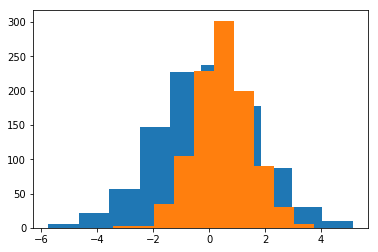

In [49]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.hist(generated[0])
plt.hist(batches_valid[0][0])